In [1]:
!kaggle datasets download -d andrewmvd/liver-tumor-segmentation
!kaggle datasets download -d harunurroshid12/resnet50

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/liver-tumor-segmentation
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 4.82G/4.84G [00:32<00:00, 170MB/s]
100% 4.84G/4.84G [00:32<00:00, 158MB/s]
Dataset URL: https://www.kaggle.com/datasets/harunurroshid12/resnet50
License(s): unknown
 78% 65.0M/83.5M [00:01<00:00, 61.5MB/s]
100% 83.5M/83.5M [00:01<00:00, 73.4MB/s]


In [2]:
!unzip -o liver-tumor-segmentation.zip -d /content/liver_tumor_segmentation
!unzip -o resnet50.zip -d /content/resnet50

Archive:  liver-tumor-segmentation.zip
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-0.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-1.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-10.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-100.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-101.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-102.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-103.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-104.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-105.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-106.nii  
  inflating: /content/liver_tumor_segmentation/segmentations/segmentation-107.nii  
  inflating: /content/liver_tumor_segmenta

In [3]:
import os
import pandas as pd


dir1 = '/content/liver_tumor_segmentation'
dir2 = '/content/resnet50'


files = []
for dirname, _, filenames in os.walk(dir1):
    for filename in filenames:
        files.append((dirname, filename))

for dirname, _, filenames in os.walk(dir2):
    for filename in filenames:
        files.append((dirname, filename))


df_files = pd.DataFrame(files, columns=['dirname', 'filename'])


In [4]:
# Sort the DataFrame
df_files = df_files.sort_values(by='filename')

print(df_files.head())


                                             dirname              filename
182                                /content/resnet50   resnet50_weights.h5
120  /content/liver_tumor_segmentation/segmentations    segmentation-0.nii
79   /content/liver_tumor_segmentation/segmentations    segmentation-1.nii
136  /content/liver_tumor_segmentation/segmentations   segmentation-10.nii
51   /content/liver_tumor_segmentation/segmentations  segmentation-100.nii


In [5]:
!pip install nibabel
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
import random
from matplotlib.pyplot import figure
import nibabel as nib
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.2 MB/s eta 0:00:00


In [6]:
# Map CT scan and label

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/content/liver_tumor_segmentation"


df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

df_files

,dirname,filename,mask_dirname,mask_filename
0,/content/liver_tumor_segmentation/volume_pt1,volume-0.nii,/content/liver_tumor_segmentation,segmentation-0.nii
1,/content/liver_tumor_segmentation/volume_pt1,volume-1.nii,/content/liver_tumor_segmentation,segmentation-1.nii
2,/content/liver_tumor_segmentation/volume_pt1,volume-10.nii,/content/liver_tumor_segmentation,segmentation-10.nii
3,/content/liver_tumor_segmentation/volume_pt2,volume-11.nii,/content/liver_tumor_segmentation,segmentation-11.nii
4,/content/liver_tumor_segmentation/volume_pt2,volume-12.nii,/content/liver_tumor_segmentation,segmentation-12.nii
5,/content/liver_tumor_segmentation/volume_pt2,volume-13.nii,/content/liver_tumor_segmentation,segmentation-13.nii
6,/content/liver_tumor_segmentation/volume_pt2,volume-14.nii,/content/liver_tumor_segmentation,segmentation-14.nii
7,/content/liver_tumor_segmentation/volume_pt2,volume-15.nii,/content/liver_tumor_segmentation,segmentation-15.nii
8,/content/liver_tumor_segmentation/volume_pt2,volume-16.nii,/content/liver_tumor_segmentation,segmentation-16.nii
9,/content/liver_tumor_segmentation/volume_pt2,volume-17.nii,/content/liver_tumor_segmentation,segmentation-17.nii


In [7]:
import os
print(os.listdir("/content/liver_tumor_segmentation"))


['volume_pt1', 'segmentations', 'volume_pt2', 'volume_pt3', 'volume_pt5', 'volume_pt4']


In [8]:
# Ensure the 'mask_dirname' only contains '/segmentations'
df_files["mask_dirname"] = "/content/liver_tumor_segmentation/segmentations"

# Verify
sample = 5
file_path = df_files.loc[sample, 'mask_dirname'] + "/segmentation-" + str(sample) + ".nii"
print(f"Full file path: {file_path}")


import nibabel as nib
ct_scan = nib.load(file_path)
array = ct_scan.get_fdata()
print(f"Array shape: {array.shape}")


Full file path: /content/liver_tumor_segmentation/segmentations/segmentation-5.nii
Array shape: (512, 512, 537)


In [9]:
import nibabel as nib
def read_nii(file_path):
    nii_image = nib.load(file_path)
    return nii_image.get_fdata()
sample = 40

# Read a CT scan file using the 'read_nii' function
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])


sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])


print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 74)
Mask Shape: (512, 512, 74)


In [10]:
# Preprocess the nii file(PyTorch's)
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

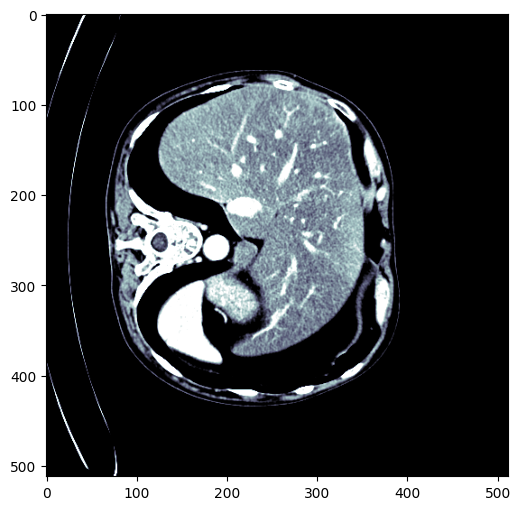

In [11]:

@patch
#The result is a tensor with pixel values scaled between 0 and 1, representing the windowed image.
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

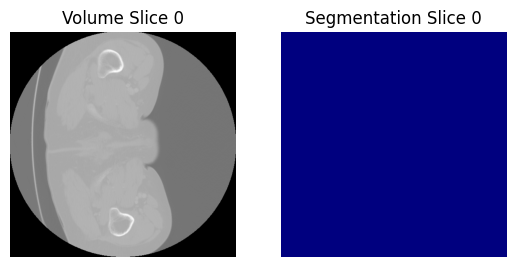

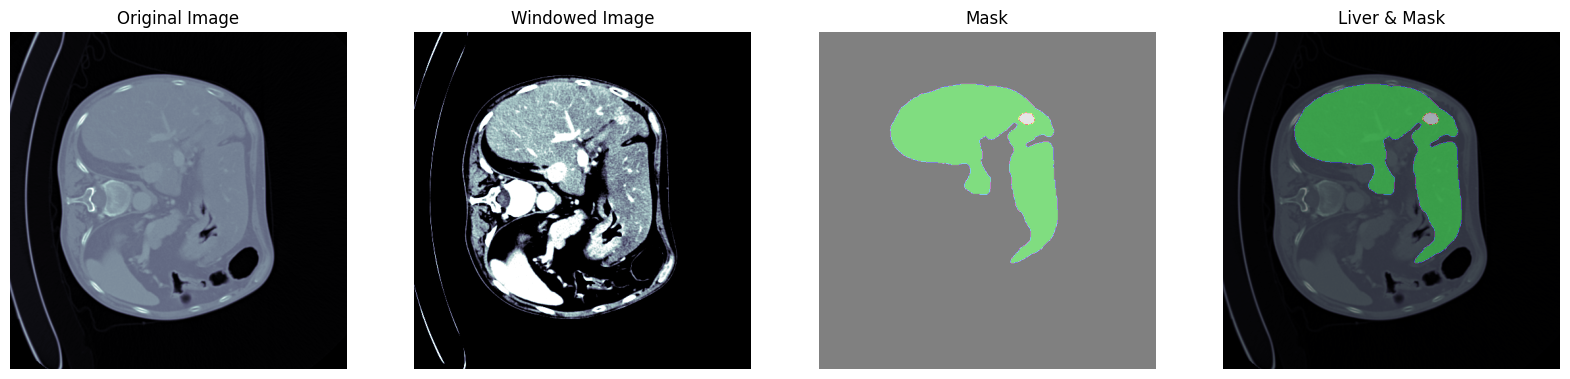

In [12]:
"""# 3.2- Read 'nii' File and Show Original Data"""


# Load the NIfTI file
volume_nifti = nib.load('/content/liver_tumor_segmentation/volume_pt1/volume-0.nii')

segmentation_nifti = nib.load('/content/liver_tumor_segmentation/segmentations/segmentation-0.nii')


volume_data = volume_nifti.get_fdata()
segmentation_data = segmentation_nifti.get_fdata()


slice_index = 0


plt.subplot(1, 2, 1)
plt.imshow(volume_data[..., slice_index], cmap='gray')
plt.title('Volume Slice {}'.format(slice_index))
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(segmentation_data[..., slice_index], cmap='jet')
plt.title('Segmentation Slice {}'.format(slice_index))
plt.axis('off')

plt.show()

def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')

    plt.show()

sample = 40

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])

<Axes: >

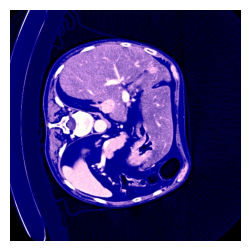

In [13]:
"""# 3.3- Preprocessing Functions"""

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'} # handle black-and-white images.

@patch
def freqhist_bins(self: Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.reshape(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins + (1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd) * t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [14]:
"""# 4- Generate *Unet Training* Image From 'nii' File"""

GENERATE_JPG_FILES = True

if GENERATE_JPG_FILES:

    path = Path(".")

    os.makedirs('train_images', exist_ok=True)
    os.makedirs('train_masks', exist_ok=True)


    os.makedirs('test_images', exist_ok=True)
    os.makedirs('test_masks', exist_ok=True)

    train_df, test_df = train_test_split(df_files, test_size=0.1, random_state=42)


    print("Length of train_df:", len(train_df))


    train_df = train_df.reset_index(drop=True)

    print("Length of test_df:", len(test_df))
    test_df = test_df.reset_index(drop=True)

    # Loop for training set
    for ii in tqdm(range(len(train_df))):
        curr_ct = read_nii(train_df.loc[ii, 'dirname'] + "/" + train_df.loc[ii, 'filename'])
        curr_mask = read_nii(train_df.loc[ii, 'mask_dirname'] + "/" + train_df.loc[ii, 'mask_filename'])
        curr_file_name = str(train_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

    ### test image save
    for ii in tqdm(range(len(test_df))):
        curr_ct = read_nii(test_df.loc[ii, 'dirname'] + "/" + test_df.loc[ii, 'filename'])
        curr_mask = read_nii(test_df.loc[ii, 'mask_dirname'] + "/" + test_df.loc[ii, 'mask_filename'])
        curr_file_name = str(test_df.loc[ii, 'filename']).split('.')[0]
        curr_dim = curr_ct.shape[2]

        for curr_slice in range(0, curr_dim, 2):
            data = tensor(curr_ct[..., curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[..., curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"test_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver, dicom_windows.custom])
            mask.save(f"test_masks/{curr_file_name}_slice_{curr_slice}_mask.png")

else:
    path = Path("../input/liver-segmentation-with-fastai-v2")  # read jpg from saved kernel output

Length of train_df: 45
Length of test_df: 6


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
"""# 4.1- Show Data"""

print("\nFirst few rows of Training Set:")
print(train_df.head())

print("\nFirst few rows of Testing Set:")
print(test_df.head())

print("\ntrain df data shape:")
print(train_df.shape)

print("\ntest df data shape:")
print(test_df.shape)


First few rows of Training Set:
                                        dirname       filename  \
0  /content/liver_tumor_segmentation/volume_pt3  volume-24.nii   
1  /content/liver_tumor_segmentation/volume_pt4  volume-38.nii   
2  /content/liver_tumor_segmentation/volume_pt2  volume-11.nii   
3  /content/liver_tumor_segmentation/volume_pt4  volume-36.nii   
4  /content/liver_tumor_segmentation/volume_pt2  volume-20.nii   

                                      mask_dirname        mask_filename  
0  /content/liver_tumor_segmentation/segmentations  segmentation-24.nii  
1  /content/liver_tumor_segmentation/segmentations  segmentation-38.nii  
2  /content/liver_tumor_segmentation/segmentations  segmentation-11.nii  
3  /content/liver_tumor_segmentation/segmentations  segmentation-36.nii  
4  /content/liver_tumor_segmentation/segmentations  segmentation-20.nii  

First few rows of Testing Set:
                                        dirname       filename  \
0  /content/liver_tumor_segm

In [16]:
"""# 5- Resizing Images"""
import os

train_images_dir = './train_images'
train_masks_dir = './train_masks'


all_image_file_names = sorted(os.listdir(train_images_dir))


sample_size = min(9000, len(all_image_file_names))


selected_image_file_names = random.sample(all_image_file_names, sample_size)


target_size = (128, 128)
train_images = [np.array(Image.open(os.path.join(train_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]


mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
train_masks = [np.array(Image.open(os.path.join(train_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]


train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Normalize images to [0, 1]
train_images =train_images / 255.0


train_masks =train_masks.reshape((train_masks.shape[0], train_masks.shape[1], train_masks.shape[2], 1))


test_images_dir = './test_images'
test_masks_dir = './test_masks'


all_image_file_names = sorted(os.listdir(test_images_dir))


sample_size = min(9000, len(all_image_file_names))


selected_image_file_names = random.sample(all_image_file_names, sample_size)


target_size = (128, 128)
test_images = [np.array(Image.open(os.path.join(test_images_dir, fname)).resize(target_size)) for fname in selected_image_file_names]


mask_file_names = [fname.replace('.jpg', '_mask.png') for fname in selected_image_file_names]
test_masks = [np.array(Image.open(os.path.join(test_masks_dir, fname)).resize(target_size)) for fname in mask_file_names]


test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Normalize images to [0, 1]
test_images =test_images / 255.0


test_masks =test_masks.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 1))

print(f"Train image ={len(train_images)} Test image={len(test_images)}")
print(f"Train mask ={len(train_masks)}  Test mask={len(test_masks)}")


Train image =8556 Test image=699
Train mask =8556  Test mask=699


train image=(8556, 128, 128, 3) and train_masks=(8556, 128, 128, 1)
X valid shape =(466, 128, 128, 3) x_test=(233, 128, 128, 3)
y valid shape =(466, 128, 128, 1)  y_test=(233, 128, 128, 1)


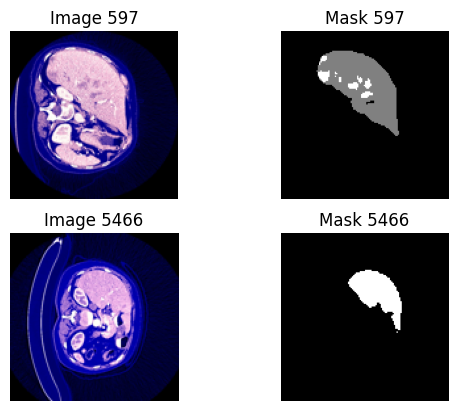

In [17]:
"""# 6- Split Data Train Test and Validation"""

x_valid, x_test, y_valid, y_test = train_test_split(test_images, test_masks, test_size=1/3, random_state=42)

print(f"train image={train_images.shape} and train_masks={train_masks.shape}")
print(f"X valid shape ={x_valid.shape} x_test={x_test.shape}")
print(f"y valid shape ={y_valid.shape}  y_test={y_test.shape}")

"""# 6.1- Display Random Images and Masks"""

def display_images_and_masks(images, masks, num_samples=2):

    sample_indices = random.sample(range(images.shape[0]), num_samples)


    for i in range(num_samples):
        index = sample_indices[i]


        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(images[index])
        plt.title("Image {}".format(index))
        plt.axis("off")


        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(masks[index].squeeze(), cmap='gray')
        plt.title("Mask {}".format(index))
        plt.axis("off")


    plt.show()

# Display two random images and masks
display_images_and_masks(train_images, train_masks)

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D

def build_model(input_shape=(128, 128, 3), num_classes=1, weights_path=None):
    # Load the ResNet50 model
    base_model = ResNet50(weights=weights_path, include_top=False, input_tensor=Input(shape=input_shape))


    for layer in base_model.layers:
        layer.trainable = False


    x = base_model.output

    # upsampling and adding convolutional layers
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Add the final convolutional layer
    x = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)


    model = Model(inputs=base_model.input, outputs=x)


    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return model

In [20]:
model = build_model(weights_path='/content/resnet50/resnet50_weights.h5')

In [21]:
history = model.fit(train_images, train_masks, batch_size=32, epochs=5, validation_data=(x_valid,y_valid))

Epoch 1/5
268/268 [==============================] - 369s 1s/step - loss: 0.0510 - accuracy: 0.9824 - val_loss: 0.0372 - val_accuracy: 0.9840
Epoch 2/5
268/268 [==============================] - 367s 1s/step - loss: 0.0334 - accuracy: 0.9855 - val_loss: 0.0545 - val_accuracy: 0.9739
Epoch 3/5
268/268 [==============================] - 365s 1s/step - loss: 0.0420 - accuracy: 0.9831 - val_loss: 0.0591 - val_accuracy: 0.9835
Epoch 4/5
268/268 [==============================] - 371s 1s/step - loss: 0.1388 - accuracy: 0.9762 - val_loss: 0.0544 - val_accuracy: 0.9824
Epoch 5/5
268/268 [==============================] - 372s 1s/step - loss: 0.0310 - accuracy: 0.9869 - val_loss: 0.0339 - val_accuracy: 0.9864


In [22]:
def plot_history(history):

    plt.plot(history.history['loss'])

    plt.plot(history.history['val_loss'])

    plt.title('Model loss')

    plt.ylabel('Loss')

    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

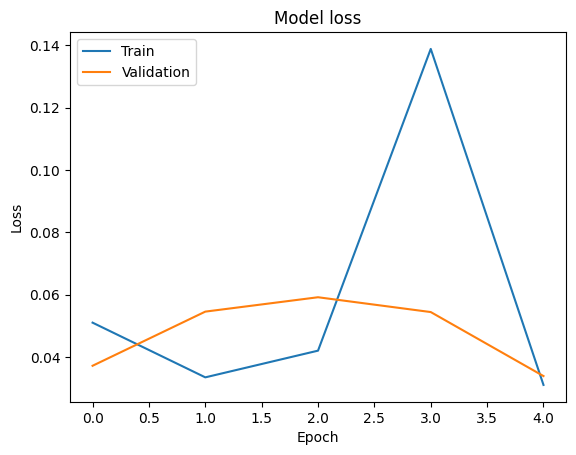

In [23]:
plot_history(history)

In [24]:
# Evaluate the model using the validation dataset.

scores = model.evaluate(x_valid, y_valid)


accuracy = scores[1]

15/15 [==============================] - 5s 346ms/step - loss: 0.0339 - accuracy: 0.9864


In [25]:
prediction = model.predict(x_test)


prediction = model.predict(x_test)


8/8 [==============================] - 3s 319ms/step


In [26]:
# Evaluate the model using the test data (x_test, y_test)
test_scores = model.evaluate(x_test, y_test)


accuracy = test_scores[1]

8/8 [==============================] - 3s 312ms/step - loss: 0.0373 - accuracy: 0.9838


1/1 [==============================] - 0s 69ms/step


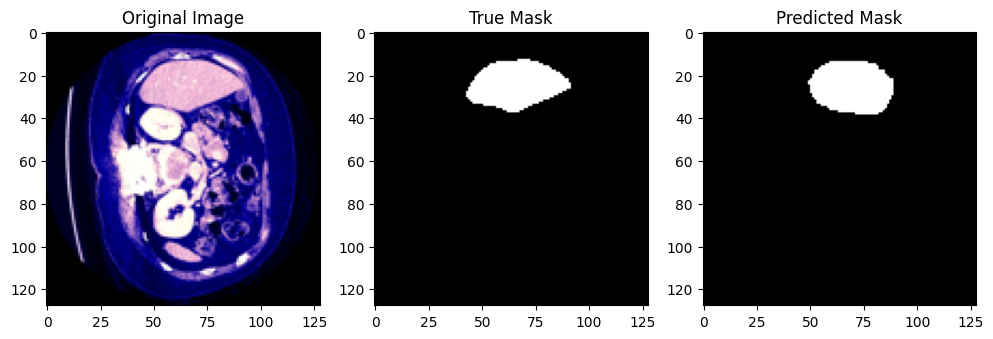

In [27]:
image_index = 44

# Load the image and true mask
input_image = x_test[image_index]
true_mask = y_test[image_index]


predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0]


threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)


plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.imshow(input_image)
plt.title('Original Image')


plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='gray')
plt.title('True Mask')


plt.subplot(1, 3, 3)
plt.imshow(predicted_mask_binary, cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [28]:
initial_segmentation_results = model.predict(x_test)

8/8 [==============================] - 3s 323ms/step


In [29]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the U-Net model architecture with detailed comments
def unet_model(input_layer):

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)


    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    up1 = UpSampling2D((2, 2))(conv3)

    concat1 = concatenate([conv2, up1], axis=-1)


    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv4)

    concat2 = concatenate([conv1, up2], axis=-1)


    outputs = Conv2D(1, (1, 1), activation='sigmoid')(concat2)


    model = Model(inputs=input_layer, outputs=outputs)
    return model


input_layer = Input(shape=(128, 128, 3), name='input_layer_1')
unet_model = unet_model(input_layer)


unet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the U-Net model
unet_model.fit(train_images, train_masks, batch_size=32, epochs=5, validation_data=(x_valid, y_valid))

Epoch 1/5
268/268 [==============================] - 242s 900ms/step - loss: 0.1309 - accuracy: 0.9659 - val_loss: 0.0383 - val_accuracy: 0.9856
Epoch 2/5
268/268 [==============================] - 242s 901ms/step - loss: 0.0377 - accuracy: 0.9859 - val_loss: 0.0339 - val_accuracy: 0.9866
Epoch 3/5
268/268 [==============================] - 241s 898ms/step - loss: 0.0335 - accuracy: 0.9869 - val_loss: 0.0302 - val_accuracy: 0.9878
Epoch 4/5
268/268 [==============================] - 241s 899ms/step - loss: 0.0307 - accuracy: 0.9877 - val_loss: 0.0295 - val_accuracy: 0.9880
Epoch 5/5
268/268 [==============================] - 244s 912ms/step - loss: 0.0293 - accuracy: 0.9881 - val_loss: 0.0282 - val_accuracy: 0.9885


In [30]:
def plot_history(history):

    plt.plot(history.history['loss'])

    plt.plot(history.history['val_loss'])

    plt.title('Model loss')

    plt.ylabel('Loss')

    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

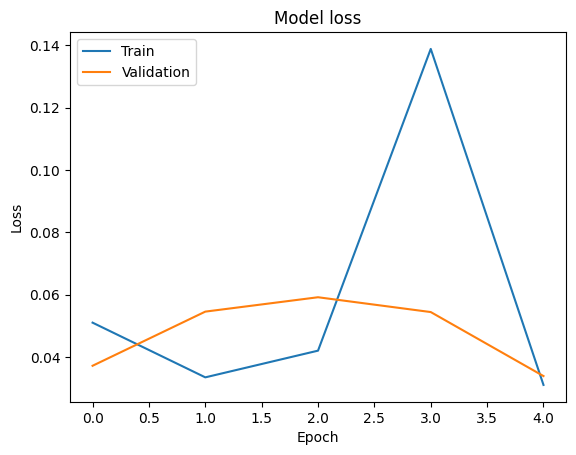

In [31]:
plot_history(history)

In [32]:
evaluation = unet_model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 174ms/step - loss: 0.0359 - accuracy: 0.9845
